<a href="https://colab.research.google.com/github/NLinh-Tran/Lending-Club-Analysis/blob/main/Lending_Club_Logistic_Regression_removed_('policy_code'%2C'addr_state'%2Cinvalid_'dti).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
wordsforthewise_lending_club_path = kagglehub.dataset_download('wordsforthewise/lending-club')

print('Data source import complete.')


Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv


# Install PySpark

In [3]:
!pip install PySpark

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import logging
import sys
import os

print('Import Libraries')

Import Libraries


In [5]:
spark = SparkSession.builder                                        \
                    .appName("LendingClubAnalysis")                 \
                    .config("spark.ui.showConsoleProgress","false") \
                    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

In [6]:
accepted_df = spark.read.option("header", True)                                             \
                        .option("inferSchema", True)                                        \
                        .option("multiLine", True)                                          \
                        .option("escape", '"')                                              \
                        .csv("/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz")

rejected_df = spark.read.option("header", True)                                            \
                        .option("inferSchema", True)                                        \
                        .option("multiLine", True)                                          \
                        .option("escape", '"')                                              \
                        .csv("/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz")

# Combined Dataset
* loan_amnt
* emp_length
* dti - **0<= dti <= 100**
* addr_state - **REMOVED**
* policy_code - **REMOVED**
* accepted_flag

In [7]:
# Accpeted
accepted_c = accepted_df.withColumn('accepted_flag', lit(1)) \
                         .select('loan_amnt', 'emp_length', 'dti', 'accepted_flag')

# Rejected
rejected_c = rejected_df.withColumnRenamed('Amount Requested', 'loan_amnt') \
                         .withColumnRenamed('Employment Length', 'emp_length') \
                         .withColumn('dti', regexp_replace(col('Debt-To-Income Ratio'), '%', '').cast('double')) \
                         .withColumn('accepted_flag', lit(0)) \
                         .select('loan_amnt', 'emp_length', 'dti', 'accepted_flag')

In [8]:
# Combine 2 datsets
combined_df = accepted_c.union(rejected_c)

combined_df = combined_df.withColumn('emp_length_years',
                                      when(col('emp_length') == '< 1 year', 0)
                                      .when(col('emp_length') == '1 year', 1)
                                      .when(col('emp_length') == '2 years', 2)
                                      .when(col('emp_length') == '3 years', 3)
                                      .when(col('emp_length') == '4 years', 4)
                                      .when(col('emp_length') == '5 years', 5)
                                      .when(col('emp_length') == '6 years', 6)
                                      .when(col('emp_length') == '7 years', 7)
                                      .when(col('emp_length') == '8 years', 8)
                                      .when(col('emp_length') == '9 years', 9)
                                      .when(col('emp_length') == '10+ years', 10)
                                      .when(col('emp_length').isNull(), -1)
                                      .otherwise(-1)) \
                          .filter((col('dti') >= 0) & (col('dti') <= 100))

combined_df = combined_df.drop('emp_length')

In [10]:
from pyspark.sql.functions import col, sum as spark_sum
combined_df.select([
    spark_sum(col(c).isNull().cast("int")).alias(c)
    for c in combined_df.columns
]).toPandas()

,loan_amnt,dti,accepted_flag,emp_length_years
0,0,0,0,0


In [9]:
combined_df.count()

27894101

# Assemble Features

* features: contains a single vector of all features per row
* label: the outcome trying to predict

In [16]:
from pyspark.ml.feature import VectorAssembler

feature_cols = ["loan_amnt", "dti", "emp_length_years"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Split into Train and Test Sets (80:20)
with random_state(seed) = 42

In [21]:
train_df, test_df = combined_df.randomSplit([0.8, 0.2], seed=42)

## Train the Logistic Regression Model

In [23]:
from pyspark.ml.classification import LogisticRegression

# Transform both sets so they contain 'features'
train_assembled = assembler.transform(train_df)
test_assembled = assembler.transform(test_df)

# Train the model
lr = LogisticRegression(featuresCol="features", labelCol="accepted_flag")
model = lr.fit(train_assembled)

# Coefficients

In [24]:
coeffs = model.coefficients.toArray()
for feature, coef in zip(feature_cols, coeffs):
    print(f"{feature}: {coef}")

loan_amnt: 1.9387059482964418e-05
dti: -0.017948761490472177
emp_length_years: 0.4164047813227267


In [29]:
coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coefficient": coeffs
})
coef_df["abs_coefficient"] = np.abs(coef_df["coefficient"])
coef_df_sorted = coef_df.sort_values("abs_coefficient", ascending=False)
coef_df_sorted

,feature,coefficient,abs_coefficient
2,emp_length_years,0.416405,0.416405
1,dti,-0.017949,0.017949
0,loan_amnt,0.000019,0.000019


## Predictions

In [26]:
predictions = model.transform(test_assembled)
predictions.select("accepted_flag", "prediction", "probability").show(5)

+-------------+----------+--------------------+
|accepted_flag|prediction|         probability|
+-------------+----------+--------------------+
|            1|       0.0|[0.92701025964443...|
|            1|       0.0|[0.97112146829990...|
|            1|       0.0|[0.91221500096051...|
|            1|       0.0|[0.95799941084349...|
|            1|       0.0|[0.97219103103093...|
+-------------+----------+--------------------+
only showing top 5 rows



## Evaluations

### 1. Classification Report & Confusion Matrix

              precision    recall  f1-score   support

    Rejected       0.95      0.98      0.96   5127930
    Accepted       0.65      0.38      0.48    451441

    accuracy                           0.93   5579371
   macro avg       0.80      0.68      0.72   5579371
weighted avg       0.92      0.93      0.93   5579371



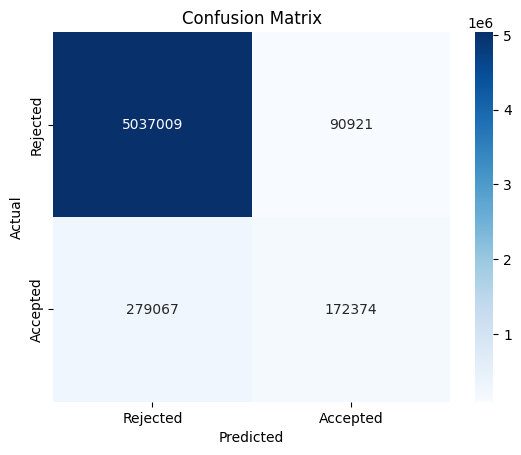

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert prediction results
preds_pd = predictions.select("accepted_flag", "prediction").toPandas()
print(classification_report(preds_pd["accepted_flag"], preds_pd["prediction"], target_names=["Rejected", "Accepted"]))

# Visualize Confusion Matrix
cm = confusion_matrix(preds_pd["accepted_flag"], preds_pd["prediction"])
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Rejected", "Accepted"], yticklabels=["Rejected", "Accepted"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## 2. AUC

In [28]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="accepted_flag")
print("AUC:", evaluator.evaluate(predictions))

AUC: 0.8644822196857993
